In [1]:
using Revise
using LazySets
using DifferentialEquations
using LazySets
using ProgressBars
using JLD2
using Flux
using LinearAlgebra
using Zygote
using ReverseDiff
using Plots
using Statistics
using Optimisers, ParameterSchedulers


In [2]:
using CUDA

# Check if GPU is available
if CUDA.functional()
    device!(2)
    CUDA.allowscalar(false)  # Disallow scalar operations on the GPU (optional)
else
    println("GPU is not available. Using CPU.")
end

In [2]:
include("dataset.jl")
X = Hyperrectangle(low = [0, 0, -1, -1], high = [4,4, 1, 1])
U = Hyperrectangle(low = [-1, -1], high = [1,1])
X_unsafe = Hyperrectangle(low = [1.5, 0, -1, -1], high = [2.5,2, 1, 1])

A = [0. 0 1 0;
    0 0 0 1;
    0 0 0 0;
    0 0 0 0;]
B = [0. 0;
    0 0;
    1 0;
    0 1;]

4×2 Matrix{Float64}:
 0.0  0.0
 0.0  0.0
 1.0  0.0
 0.0  1.0

In [3]:
raw_training_data = load_object("point_seq_training_data.jld2")
raw_test_data = load_object("point_seq_test_data.jld2")

3×10001 Matrix{AbstractVector{Float64}}:
 [2.31642, 1.9133, -0.147242, -0.804865]  …  [2.48529, 0.0859108, -0.380176, 0.553731]
 [-0.562398, 0.564786]                       [0.5988, -0.935063]
 [0.0]                                       [0.0]

In [7]:
include("affine_dynamics.jl")
using Flux
using ProgressBars
using JLD2

batchsize = 128
@show sum(raw_training_data[3,:]), size(raw_training_data[3,:])
state_dim = size(reduce(hcat,raw_training_data[1,:]))[1]


training_data = raw_training_data
test_data = raw_test_data

# model = Chain(
#     Dense(4 => 16, relu),   # activation function inside layer
#     Dense(16 => 64, relu),   # activation function inside layer
#     Dense(64 => 16, relu),   # activation function inside layer
#     Dense(16 => 1)
# )

model = Chain(
    Dense(4 => 8, relu),   # activation function inside layer
    Dense(8 => 8, relu),   # activation function inside layer
    Dense(8 => 8, relu),   # activation function inside layer
    Dense(8 => 1)
)

train_loader = Flux.DataLoader(training_data, batchsize=batchsize, shuffle=true)
test_loader = Flux.DataLoader(test_data, batchsize=batchsize, shuffle=true)

λ = 1
μ = 1
α = 0.0
use_pgd=true
use_adv = true
lr_lambda = 0.0001
mu = 0.9
V_lambda=0

lr_decay_rate = 0.2
lr_decay_epoch =4
total_epoch = 20

ini_lr = 0.01
optim = Flux.setup(Flux.Optimise.NADAM(ini_lr, (0.9, 0.999), 0.1), model)  # will store optimiser momentum, etc.
sched = ParameterSchedulers.Stateful(Step(ini_lr, lr_decay_rate, lr_decay_epoch)) # setup schedule of your choice

training_losses = []
test_losses = []
least_loss = 1000
test_loss = 0
loss = 0
for epoch in ProgressBar(1:total_epoch)
    training_loss_epcoh = []
    test_loss_epcoh = []
    ∇l_lambda = 0
    ∇l_alpha = 0
    for item in train_loader
        ∇l_alpha = 0
        ∇l_lambda = 0
        x_batch = reduce(hcat,item[1,:])
        u_batch = reduce(hcat,item[2,:])
        y_init_batch = reduce(hcat,item[3,:])
        use_pgd && (u_batch = pgd_find_u_notce(model, A, x_batch, B, u_batch, U; α = α))
        if use_adv
            X_lcoal = [Hyperrectangle(x_batch[:, i], radius_hyperrectangle(X) ./ 20) for i=1:size(x_batch)[2]]
            x_batch = pgd_find_x_notce(model, A, x_batch, B, u_batch, X_lcoal; α = α)
        else
            x_batch = x_batch
        end
        use_pgd && (u_batch = pgd_find_u_notce(model, A, x_batch, B, u_batch, U; α = α))
        training_loss, grads = Flux.withgradient(model) do m 
            loss_naive_safeset(m, x_batch, y_init_batch) + λ .* loss_naive_fi(m, A, x_batch, B, u_batch,y_init_batch;use_pgd=false,use_adv = false, α=α) + μ .* loss_regularization(m, x_batch, y_init_batch)
        end
        Flux.update!(optim, model, grads[1])

        loss = loss_naive_safeset(model, x_batch, y_init_batch) + λ .* loss_naive_fi(model, A, x_batch, B, u_batch,y_init_batch;use_pgd=use_pgd,use_adv = false, α=α) + μ .* loss_regularization(model, x_batch, y_init_batch)
        push!(training_loss_epcoh, loss)  # logging, outside gradient context
        
    end
    for item in test_loader
        x_batch = reduce(hcat,item[1,:])
        u_batch = reduce(hcat,item[2,:])
        y_init_batch = reduce(hcat,item[3,:])

        test_loss =  loss_naive_safeset(model, x_batch, y_init_batch) + λ .* loss_naive_fi(model, A, x_batch, B, u_batch,y_init_batch;use_pgd=use_pgd,use_adv = false, α=α) + μ .* loss_regularization(model, x_batch, y_init_batch)
        push!(test_loss_epcoh, test_loss)
    end
    nextlr = ParameterSchedulers.next!(sched) # advance schedule
    Optimisers.adjust!(optim, nextlr) # update optimizer state, by default this changes the learning rate `eta`
    lr_lambda = lr_lambda * lr_decay_rate^(floor(epoch / lr_decay_epoch))
    @show epoch, loss, test_loss
    model_state = Flux.state(model)
    jldsave("point_adv20_small_model_1_0_1_pgd_relu_$epoch.jld2"; model_state)
    push!(training_losses, sum(training_loss_epcoh)) 
    push!(test_losses, sum(test_loss_epcoh))

end


(sum(raw_training_data[3, :]), size(raw_training_data[3, :])) = ([1.43765e6], (2577770,))


0.0%┣                                               ┫ 0/20 [00:00<00:00, -0s/it]


(epoch, loss, test_loss) = (1, 0.018475917172256228, 0.042440682053500475)


5.0%┣██                                      ┫ 1/20 [01:15:22<Inf:Inf, InfGs/it]


(epoch, loss, test_loss) = (2, 0.03140338482087708, 0.007003469075628315)


10.0%┣███▉                                  ┫ 2/20 [02:32:36<45:46:55, 9.2ks/it]


(epoch, loss, test_loss) = (3, 0.018097217924837608, 0.014303897289980013)


15.0%┣█████▊                                ┫ 3/20 [04:16:35<36:21:01, 7.7ks/it]


(epoch, loss, test_loss) = (4, 0.01553929193612334, 0.01811611467351461)


20.0%┣███████▋                              ┫ 4/20 [05:53:49<31:27:01, 7.1ks/it]


(epoch, loss, test_loss) = (5, 0.05848269098371288, 0.020465323828897125)


25.0%┣█████████▌                            ┫ 5/20 [07:35:38<28:28:37, 6.8ks/it]


(epoch, loss, test_loss) = (6, 0.005717928349415285, 0.001328210851377647)


30.0%┣███████████▍                          ┫ 6/20 [09:32:47<26:43:48, 6.9ks/it]


(epoch, loss, test_loss) = (7, 0.039808670428298505, 0.001885637089661165)


35.0%┣█████████████▎                        ┫ 7/20 [11:28:09<24:50:59, 6.9ks/it]


(epoch, loss, test_loss) = (8, 0.015768282048716165, 0.004430958577781102)


40.0%┣███████████████▏                      ┫ 8/20 [13:23:23<22:57:14, 6.9ks/it]


(epoch, loss, test_loss) = (9, 0.03132013399612489, 0.012723255140612141)


45.0%┣█████████████████                     ┫ 9/20 [15:16:17<20:59:53, 6.9ks/it]


(epoch, loss, test_loss) = (10, 0.007015336379774598, 0.001413356101171952)


50.0%┣██████████████████▌                  ┫ 10/20 [17:04:55<18:58:48, 6.8ks/it]


(epoch, loss, test_loss) = (11, 0.013252866629512585, 0.005080408509004809)


55.0%┣████████████████████▍                ┫ 11/20 [18:48:07<16:55:18, 6.8ks/it]


(epoch, loss, test_loss) = (12, 0.0023935168642191056, 0.0011683440431917208)


60.0%┣██████████████████████▏              ┫ 12/20 [20:31:06<14:55:21, 6.7ks/it]


(epoch, loss, test_loss) = (13, 0.003292918978248357, 0.047190285096582504)


65.0%┣████████████████████████             ┫ 13/20 [22:22:24<13:03:04, 6.7ks/it]


(epoch, loss, test_loss) = (14, 0.0218709336426335, 0.006052261041051876)


70.0%┣██████████████████████████           ┫ 14/20 [24:18:26<11:13:07, 6.7ks/it]


(epoch, loss, test_loss) = (15, 0.01274118903915845, 0.006825350329948787)


75.0%┣███████████████████████████▊         ┫ 15/20 [26:16:18<09:22:58, 6.8ks/it]


(epoch, loss, test_loss) = (16, 0.03223387228536648, 0.007123791083166435)


80.0%┣█████████████████████████████▋       ┫ 16/20 [28:11:36<07:31:06, 6.8ks/it]


(epoch, loss, test_loss) = (17, 0.017667923072576208, 0.014380830153764804)


85.0%┣███████████████████████████████▌     ┫ 17/20 [30:01:13<05:37:44, 6.8ks/it]


(epoch, loss, test_loss) = (18, 0.012511108840883783, 0.0017697484764113778)


90.0%┣█████████████████████████████████▎   ┫ 18/20 [31:50:13<03:44:44, 6.7ks/it]


(epoch, loss, test_loss) = (19, 0.009537555776570549, 0.0004250482638725861)


95.0%┣███████████████████████████████████▏ ┫ 19/20 [33:38:27<01:52:08, 6.7ks/it]


(epoch, loss, test_loss) = (20, 0.006971487008361659, 0.0036293110705333336)


100.0%┣███████████████████████████████████████┫ 20/20 [35:26:17<00:00, 6.7ks/it]
100.0%┣███████████████████████████████████████┫ 20/20 [35:26:17<00:00, 6.7ks/it]


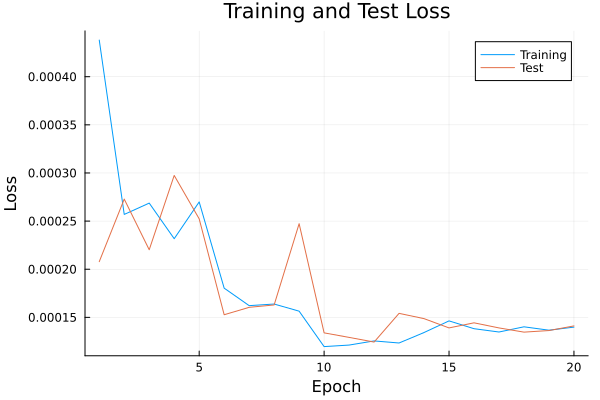

In [8]:
using Plots

function plot_loss(train_loss::Vector, test_loss::Vector; xlabel="Epoch", ylabel="Loss", title="Training and Test Loss")
    plot(train_loss ./ (size(training_data[3,:] / batchsize)), label="Training", xlabel=xlabel, ylabel=ylabel, title=title)
    plot!(test_loss ./ (size(test_data[3,:] / batchsize)), label="Test")
end

plot_loss(training_losses, test_losses)